MSM-analysis for alanine-dipeptide
====================================

This notebook collects usage examples for MSM-analysis using members of the pyemma.msm.analysis package. 

A given MSM, estimated from alanine-dipeptide simulation data at lagtime $\tau=6ps$, is used as an example to carry out analysis.

The necessary inputs are:

1. the transition matrix, 'T.dat'
2. the centers of the $(\phi, \psi)$ dihedral angle space regular grid discretization, 'grid_centers20x20.dat'
3. the largest set of connected microstates, 'lcc.dat'

Auxiliary functions in 'plotting.py' are used to generate figures of the estimated quantities.

First we import PyEMMA and check the version number.

In [1]:
import pyemma
pyemma.__version__

u'1.2+376.ge5a81e7'

This notebook has been tested for version 1.2.2. If you are using a different version some adaptations may be required.

Use ipythons magic % commands to activate plotting within notebook cells

In [2]:
%matplotlib inline

Import required packages und function:

In [3]:
import numpy as np
import pyemma.msm as msm

In [4]:
from pyemma.msm.analysis import stationary_distribution, eigenvectors, eigenvalues, timescales, pcca

In [5]:
import plotting

Load Alanine dipeptide transition matrix and input data
-----------------------
This analysis starts from the transition matrix and requires some input data which are loaded here.
Use pyemma.msm.io.read_matrix function to read dense arrays from ascii files. The returned objects will be dense arrays (numpy.ndarray).

load transition matrix:

In [6]:
T=msm.io.read_matrix('T.dat')

load grid centers:

In [7]:
centers=msm.io.read_matrix('grid_centers20x20.dat')

load cluster centers:
The optional dtype (data-type) keyword allows you to specify the type of the read data. The default value is dtype=float. 

In [8]:
lcc=msm.io.read_matrix('lcc.dat', dtype=int)

Use the integer values given by the largest connected set as indices to "slice" the array of grid-center points. The returned array contains only those centers corresponding to the mircrostates in the largest connected set.

In [9]:
centers=centers[lcc, :]

Estimate MSM and calculate stationary distribution
========================

Compute the stationary distribution using the pyemma.msm.analysis.stationary_distribution method.

In [10]:
model = msm.markov_model(T)

In [11]:
pi=model.stationary_distribution

The (centers, pi) tuple is fed into an adapted plotting subroutine producing a contour plot from the scattered data. Since scatterd data can not directly be used to produce a contour plot over the whole $(\phi, \psi)$-plane the given data is interpolated onto a regular grid before producing a contour plot. Some of the strange-looking low probability iso-lines may be artefacts of the interpolation. Interpolation on the level of free energies is probably a better idea.

/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


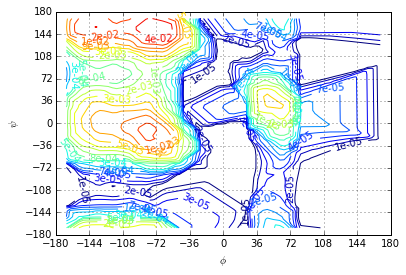

In [12]:
plotting.stationary_distribution(centers, pi)

For $T=300K$ we have $\beta=0.4 \frac{mol}{kJ}$. The free-energy is defined as $A_i=-\frac{1}{\beta} \log \pi_i$

In [13]:
A=-1.0/0.4*np.log(pi)

Since we can only estimate free-energy differences we set the $\min{A_i}=0$



In [14]:
A=A-A.min()

For plotting we chose the equally spaced contour levels in the interval $[0, 30] \frac{kJ}{mol}$. For the interpolation onto a regular grid we chose cubic splines. Grid points that lie outside of the convex-hull of the given center points are assigned the maximum value of $A$.

The plot shows the separation of the dihedral plane into a low (free-)energy region $ \phi \leq 0 $ and the region of high free-energy $\phi >0$.

* The low lying region contains three metastable sets seperated by a barrier of approximately $4 \frac{kJ}{mol}$ and  approximately $10 \frac{kJ}{mol}$.

* There are two metastable sets in the high energy region seperated by a barrier of approximately $7 \frac{kJ}{mol}$. 

* The barrier between the low energy and the high energy region is approximately $23 \frac{kJ}{mol}$.

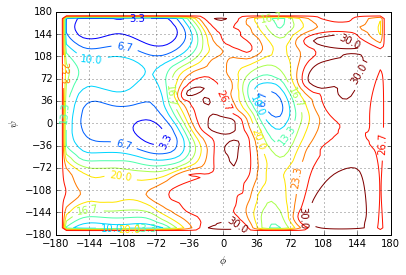

In [15]:
plotting.free_energy(centers, A, levels=np.linspace(0.0, 30.0, 10), method='cubic', fill_value=A.max())

Eigenvectors
-----------

We compute the right eigenvectors corresponding to the 4 largest eigenvalues.

In [16]:
R=eigenvectors(T, k=4)

The first eigenvector shows a sign change from the  most stable region with $\phi \leq 0$ to the $\phi>0$ region. The slowest process corresponds to a transition between the two most stable states and the metastable regions with $\phi>0$.

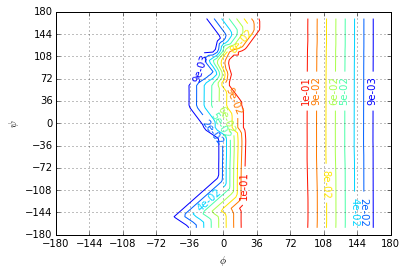

In [17]:
ev=R[:, 1].real
plotting.eigenvector(centers, ev, levels=np.linspace(ev.min(), ev.max(), 10))

The second eigenvector shows a sign change from $\phi \leq 0$ to $\phi>0$. The second slowest process is the transition between the low-probability region $\phi>0$ and the high probability region $\phi \leq 0$.

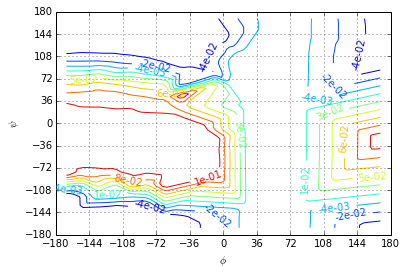

In [18]:
ev=R[:, 2].real
plotting.eigenvector(centers, ev, levels=np.linspace(ev.min(), ev.max(), 11), fmt='%.e')

The third eigenvector shows the transition process between the least probable meta-stable state and the rest of the accessible state space.

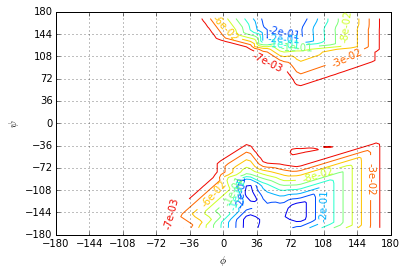

In [19]:
ev=R[:, 3].real
plotting.eigenvector(centers, ev, levels=np.linspace(ev.min(), ev.max(), 11), fmt='%.e')

Eigenvalues
----------
Compute the 10 largest eigenvalues of the MSM

In [20]:
eigvals=eigenvalues(T)[0:11]

The first $5$ eigenvalues are purely real. The remaining eigenvalues occur in complex-conjugate pairs. That is because $T$ is a matrix with purely real entries.

In [21]:
eigvals

array([ 1.00000000+0.j,  0.99605599+0.j,  0.91809032+0.j,  0.85265885+0.j,
        0.15180064+0.j, -0.14487821+0.j,  0.13748748+0.j,  0.13178927+0.j,
       -0.13090684+0.j,  0.12917406+0.j, -0.10742285+0.j])

There is a distinct gap in the spectrum betwenn the third and the fourth eigenvalue.

/storage/mi/nplattner/miniconda/envs/PyE_1.2.2/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


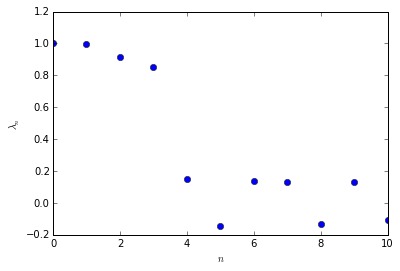

In [22]:
plotting.eigenvalues(eigvals)

Implied time scales
-----------------

Implied time scales are computed via msm.analysis.timescales. The lagtime of the Markov model, $\tau=6 ps$, can be specified via the optional keyword tau. The default value is tau=1.

In [23]:
n_its=5  # number of timescales to calculate
its=timescales(T, k=n_its, tau=6)

In [24]:
print 'implied timescales (in ps) for the ', n_its, ' slowest processes: \n'
for i in range(n_its):
    print 'process ',i,':\t', its[i]

implied timescales (in ps) for the  5  slowest processes: 

process  0 :	inf
process  1 :	1518.2910797
process  2 :	70.2086887009
process  3 :	37.642156558
process  4 :	3.18270776782


PCCA
----

Now we calculate metastable states using the PCCA+ method. For this we first have to choose a number of metastable states.

In [25]:
nmeta = 5     # number of metastable states
model.pcca(nmeta)  # do PCCA
membership=model.metastable_memberships  # get PCCA memberships

In [26]:
membership_crisp=np.where(membership>0.4)

PCCA gives accurate memberships for the high probability region. Assigning correct memberships for the low probability states, $\phi>0$, is problematic.

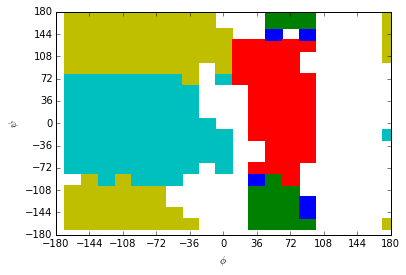

In [27]:
plotting.pcca(centers, membership_crisp)

Summary
-------

The pyemma.msm.analysis module can be used to analyse an estimated transition matrix. Starting from the transition matrix $T$ It is possible to

* compute the stationary vector $\pi$ to analyze the free-energy landscape given suitable (low-dimensional) coordinates
* compute the right eigenvectors to investigate slowest dynamical processes
* compute eigenvalues and time scales as quantitative information about system-dynamics

The pyemma.msm-API is designed to allow fast and flexible scripting of the whole estimation and analysis process. There is a multitude of functions for MSM analysis provided in the emma2.msm.analysis module. Further functions are

* checks for stochasticity, ergodicity, etc.
* commitor computation
* TPT
* mean-first-passage time (mfpt) computations
* fingerprint: expectation and autocorrelation
* decompositions in eigenvalues, left, and right eigenvectors

We are happy for your feedback and suggestions. Please feel free to contact our mailing list at emma@lists.fu-berlin.de
